# Government Contract Award Analysis for Small Business Classification
Data source: [USASpending.gov](https://usaspending.gov/search)  
- ___Focus:___ Contracts awarded to __small businesses__ between 01.01.2018 through 12.31.2020, within the NAICS code 541620 (Environmental Services).*  
- ___Primary Metrics:___ Each small business's number of contracts awarded (counts of unique `award_id`'s) and the federal dollars obligated (`dollars_obligated`).
- ___Purpose:___ Gather information about other businesses with similar metrics to the target company,** in order to identify potential acquisitions to increase target company's presence and revenue within the specified NAICS code.  

  
  
<small style="font-size: 11px">*The initial data includes all 5416 NAICS codes, and dates from 10/01/2007 through 04/27/2021.</small>  
<small style="font-size: 11px">**Target company used: Toeroek Associates, Inc.</small>  

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime as dt
from competitors import AnalyzeTarget
%matplotlib inline
style.use('fivethirtyeight')
pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.2f}'.format

target = 'TOEROEK ASSOCIATES, INC.'
primary_naics = 541620

In [2]:
# create dataframe from file
file_name = 'USAspending_award_summaries.csv'
raw_data = pd.read_csv(file_name, low_memory=False)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491554 entries, 0 to 491553
Columns: 282 entries, contract_transaction_unique_key to last_modified_date
dtypes: float64(26), int64(6), object(250)
memory usage: 1.0+ GB


In [4]:
important_cols = {
    'parent_award_id_piid': 'award_id', # contract or 'order' number. Identifier for each award.
    'award_id_piid': 'piid_ref', # used to fill missing parent_award_id_piid
    'federal_action_obligation': 'dollars_obligated', # dollars obligated/deobligated to an action
    'naics_code': 'naics_code', # NAICS code of the contract (all under the 5416 group)
    'recipient_name': 'vendor_name', # Company's name
    'award_description': 'award_description', # Text description of the contract action ob/deob
    'action_date': 'action_date', # Date a given action was taken
    'last_modified_date': 'last_modified_date',
    'number_of_actions': 'number_of_actions', # Count of each action (at lowest level typical value of 1)
    'transaction_number': 'transaction_number',
    'awarding_office_name': 'awarding_office_name', # Identifies which office region a contract is awarded by
    'primary_place_of_performance_state_code': 'states_of_performance', # State in which contract work takes place
    'primary_place_of_performance_zip_4': 'place_of_performance_zip',
    'recipient_state_code': 'vendor_location'} # Where the company (vendor) is located

keep_cols = [k for k in important_cols]
data = raw_data[keep_cols].copy()
data = data.rename(columns=important_cols)
data = data.reset_index(drop='index')

In [5]:
# Create year column based off action_date year
data['year'] = data['action_date'].str[:4].astype(float)

In [6]:
# filter for primary NAICS code target (541620)
df = data[data['naics_code'] == primary_naics].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91372 entries, 5 to 491552
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   award_id                  64409 non-null  object 
 1   piid_ref                  91372 non-null  object 
 2   dollars_obligated         91372 non-null  float64
 3   naics_code                91372 non-null  int64  
 4   vendor_name               91371 non-null  object 
 5   award_description         90624 non-null  object 
 6   action_date               91372 non-null  object 
 7   last_modified_date        91372 non-null  object 
 8   number_of_actions         91372 non-null  int64  
 9   transaction_number        91372 non-null  int64  
 10  awarding_office_name      91370 non-null  object 
 11  states_of_performance     90465 non-null  object 
 12  place_of_performance_zip  90411 non-null  object 
 13  vendor_location           91206 non-null  object 
 14  year 

In [7]:
# For comparison to the group below with no $0 obligation actions
df_no_0s = df[df['dollars_obligated'] != 0].copy()
df_no_0s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67362 entries, 5 to 491550
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   award_id                  46697 non-null  object 
 1   piid_ref                  67362 non-null  object 
 2   dollars_obligated         67362 non-null  float64
 3   naics_code                67362 non-null  int64  
 4   vendor_name               67361 non-null  object 
 5   award_description         66715 non-null  object 
 6   action_date               67362 non-null  object 
 7   last_modified_date        67362 non-null  object 
 8   number_of_actions         67362 non-null  int64  
 9   transaction_number        67362 non-null  int64  
 10  awarding_office_name      67361 non-null  object 
 11  states_of_performance     66678 non-null  object 
 12  place_of_performance_zip  66669 non-null  object 
 13  vendor_location           67224 non-null  object 
 14  year 

In [8]:
# Fill missing award_id's with the PIID code
df['award_id'] = df['award_id'].fillna(df['piid_ref'])

In [9]:
# Convert date columns to datetime dtype
for col in df.columns:
    if 'date' in col:
        df[col] = pd.to_datetime(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91372 entries, 5 to 491552
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   award_id                  91372 non-null  object        
 1   piid_ref                  91372 non-null  object        
 2   dollars_obligated         91372 non-null  float64       
 3   naics_code                91372 non-null  int64         
 4   vendor_name               91371 non-null  object        
 5   award_description         90624 non-null  object        
 6   action_date               91372 non-null  datetime64[ns]
 7   last_modified_date        91372 non-null  datetime64[ns]
 8   number_of_actions         91372 non-null  int64         
 9   transaction_number        91372 non-null  int64         
 10  awarding_office_name      91370 non-null  object        
 11  states_of_performance     90465 non-null  object        
 12  place_of_performa

In [10]:
df.describe()

,dollars_obligated,naics_code,number_of_actions,transaction_number,year
count,91372.00,91372.00,91372.00,91372.00,91372.00
mean,74599.10,541620.00,1.00,0.11,2013.82
std,348779.71,0.00,0.04,0.86,3.83
min,-22633260.00,541620.00,1.00,0.00,2007.00
25%,0.00,541620.00,1.00,0.00,2010.00
50%,4900.00,541620.00,1.00,0.00,2014.00
75%,45239.80,541620.00,1.00,0.00,2017.00
max,14558242.60,541620.00,7.00,17.00,2021.00


---
#### Everything below is based off a 3 year time period
01.01.2018 through 12.31.2020

In [11]:
df_3yr = df[df['year'].between(2018, 2020)]
# Remove $0 actions (redundant)
df_3yr = df_3yr[df_3yr['dollars_obligated'] != 0].copy()

In [12]:
def feature_engineer(df):
    df['avg_per_action'] = round(df['dollars_obligated'] / df['number_of_actions'], 2)
    df['avg_per_award'] = round(df['dollars_obligated'] / df['award_id'], 2)
    return df

def grouper(df, *args, **kwargs):
    '''
    Grouping function
    args:
        df : (pandas.DataFrame)
        *args : (str) [Required] list of columns to group by
        *kwargs : create agg function for grouping
    '''
    if not kwargs:
        kwargs = 'sum'
    grp = df.groupby([*args]).agg(kwargs)
    return grp

full_v = grouper(df_3yr,
                    'vendor_name',
                    dollars_obligated='sum',
                    award_id='nunique',
                    number_of_actions='sum',
                    year='max')


full_v = feature_engineer(full_v)
full_v

,dollars_obligated,award_id,number_of_actions,year,avg_per_action,avg_per_award
vendor_name,,,,,,
"106 GROUP LTD., THE",2500.00,1,1,2018.00,2500.00,2500.00
3D ENVIROLOGICS LLC,756950.24,1,1,2018.00,756950.24,756950.24
4 GRANITE INC,25712.00,1,1,2019.00,25712.00,25712.00
"501C3 TUNEUP, INC.",55560.96,2,2,2019.00,27780.48,27780.48
7 BISON CULTURAL CONSULTING LLC,20000.00,1,1,2019.00,20000.00,20000.00
...,...,...,...,...,...,...
Z GEO INFO INC,735777.81,1,6,2020.00,122629.64,735777.81
"ZALARVIS-CHASE, DIMITRA",13932.77,1,1,2019.00,13932.77,13932.77
ZEPHYR ENVIRONMENTAL CORP,48058.47,2,9,2020.00,5339.83,24029.24


In [13]:
vendors_3yr = grouper(df_3yr,
                      'vendor_name', 'year', 
                      dollars_obligated='sum',
                      award_id='nunique',
                      number_of_actions='sum')

vendors_3yr = feature_engineer(vendors_3yr)

In [14]:

# Remove the $0 actions (already done above, but needed freedom to turn it on and off above)
final_grp = df_3yr[df_3yr['dollars_obligated'] != 0]
final_grp = final_grp.groupby(['vendor_name', 'year'])
final_grp_agg1 = final_grp.agg({
    'award_id': 'nunique',
    'dollars_obligated': 'sum',
    'number_of_actions': 'sum',
})

grp_reset = final_grp_agg1.reset_index()

In [15]:
grp_reset['year'].value_counts()

2018.00    1027
2019.00    1024
2020.00    1005
Name: year, dtype: int64

In [16]:
filter_v3 = full_v[full_v['dollars_obligated'].between(full_v['dollars_obligated'].quantile(0), full_v['dollars_obligated'].quantile(1))]

filter_v3.describe()


,dollars_obligated,award_id,number_of_actions,year,avg_per_action,avg_per_award
count,1679.00,1679.00,1679.00,1679.00,1679.00,1679.00
mean,1090215.94,1.99,8.07,2019.42,95040.29,463437.51
std,4716083.29,2.45,21.32,0.78,261462.33,1874688.90
min,-2462798.02,1.00,1.00,2018.00,-461407.75,-922815.50
25%,8880.50,1.00,1.00,2019.00,5399.35,7603.18
50%,54959.35,1.00,2.00,2020.00,22750.00,37445.37
75%,366035.42,2.00,6.00,2020.00,78481.12,216325.13
max,119489118.73,30.00,322.00,2020.00,4992439.00,39829706.24


In [17]:

filter_v3.loc[target]

dollars_obligated   16365223.27
award_id                   8.00
number_of_actions        322.00
year                    2020.00
avg_per_action         50823.67
avg_per_award        2045652.91
Name: TOEROEK ASSOCIATES, INC., dtype: float64

In [18]:
did_business_in_2020 = filter_v3[filter_v3['year'] == 2020]

In [27]:
def quick_plot(data, x, y, labeled=False, title=None, lims=None, *args, **kwargs):
    try:
        target_line = data.loc[target]
        target_do = target_line['dollars_obligated']
        target_ai = target_line['award_id']
    except:
        pass
    if labeled:
        p1 = sns.relplot(x=x, y=y, data=data, s=100, **kwargs)
        ax = p1.axes[0,0]
        for idx, row in data.iterrows():
            x = row[0]
            y = row[1]
            text = idx
            ax.text(x, y, '<--' + text, horizontalalignment='left', rotation=45, alpha=0.5)
    else:
        sns.relplot(x=x, y=y, data=data, **kwargs)
    plt.title(title)
    if lims:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    try:
        plt.axhline(target_ai, linewidth=0.5)
        plt.axvline(target_do, linewidth=0.5);
    except:
        pass
   
    plt.ticklabel_format(style='sci', axis='x',useOffset=False, useMathText=True);

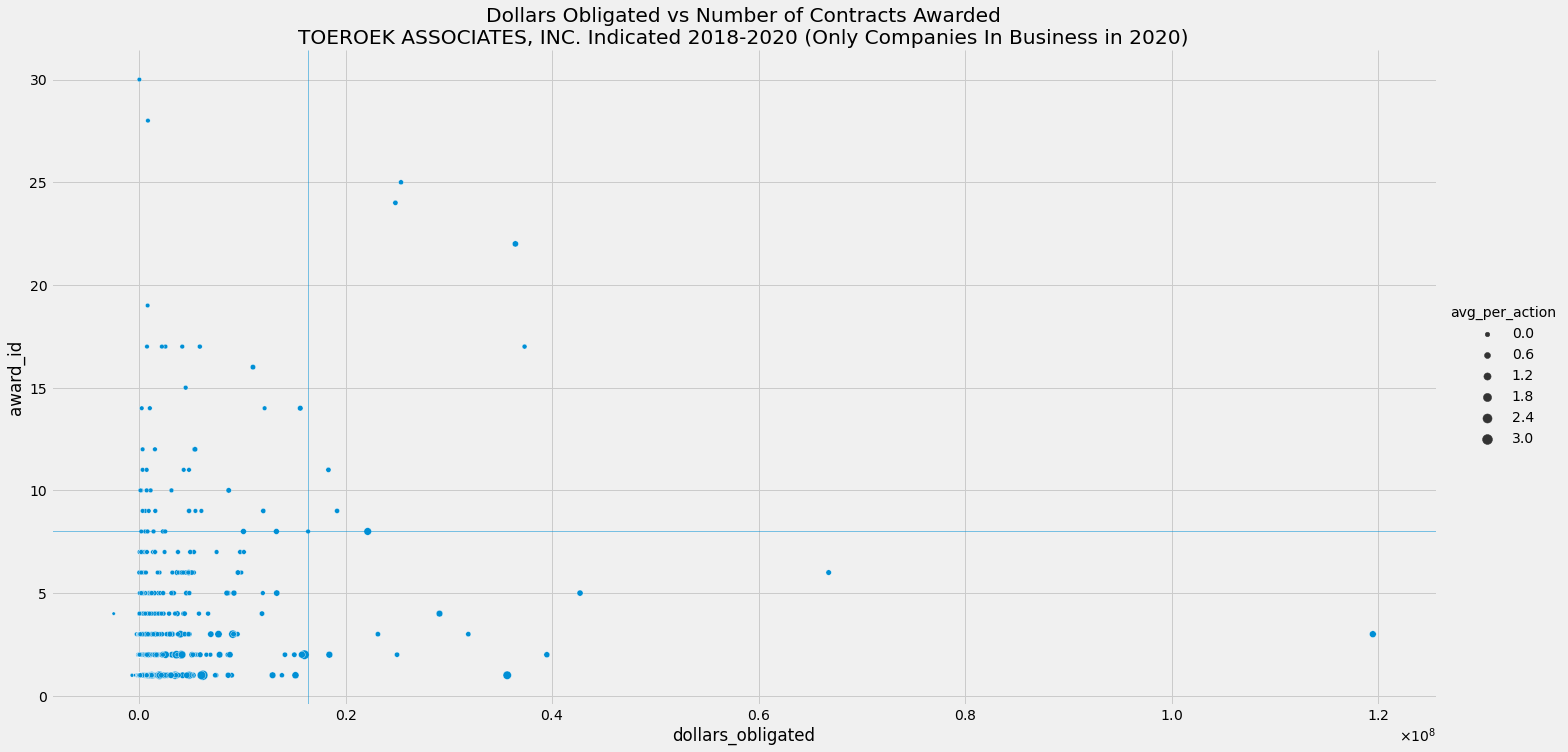

In [28]:
quick_plot(y='award_id', x='dollars_obligated',
           size='avg_per_action', sizes=(10, 100),
           palette='tab10',
           title=f'Dollars Obligated vs Number of Contracts Awarded\n{target} Indicated 2018-2020 (Only Companies In Business in 2020)',
           data=did_business_in_2020, height=10, aspect=2)

v3_reset = vendors_3yr.reset_index()
v3_reset = v3_reset.groupby('vendor_name').agg('sum')



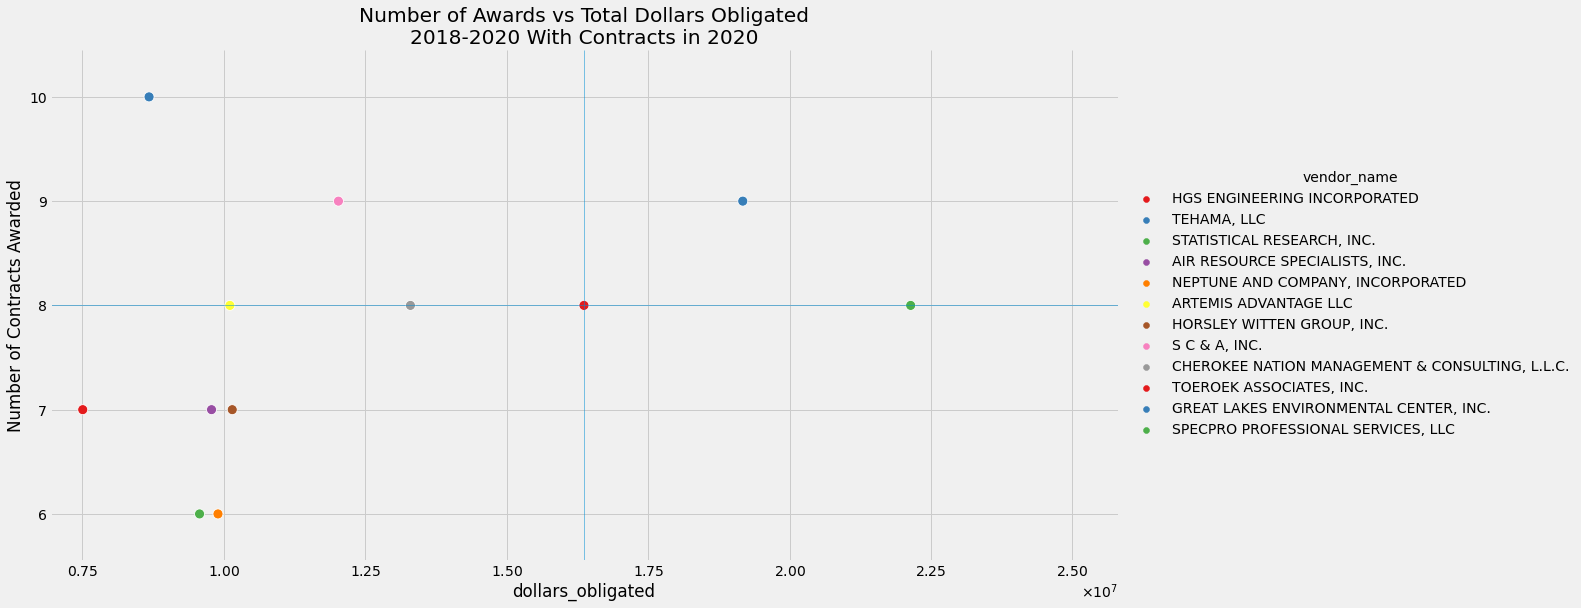

In [30]:
target_line = full_v.loc[target]
target_do = target_line['dollars_obligated']
target_ai = target_line['award_id']

# Isolate vendors within +/- 2 standard deviation of dollars_obligated and award_id for target
stds = full_v.std()
target_do_range = (target_do - stds['dollars_obligated']*2, target_do + stds['dollars_obligated']*2)
target_ai_range = (target_ai - stds['award_id'], target_ai + stds['award_id'])
metric_test1 = filter_v3[(filter_v3['dollars_obligated'].between(*target_do_range)) & (filter_v3['award_id'].between(*target_ai_range))].sort_values('dollars_obligated')

mtest = metric_test1.reset_index()
quick_plot(metric_test1,
           'dollars_obligated', 'award_id',
           title='Number of Awards vs Total Dollars Obligated\n2018-2020 With Contracts in 2020',
           lims=[target_do_range, target_ai_range],
           hue='vendor_name', s=100,
           height=8, aspect=2, palette='Set1')
plt.ylabel('Number of Contracts Awarded');


# Potential Businesses for Acquisition  

 <table border="1" class="dataframe" style="margin-left: 0;">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>dollars_obligated</th>
      <th>award_id</th>
      <th>number_of_actions</th>
   
      <th>avg_per_action</th>
      <th>avg_per_award</th>
    </tr>
    <tr>
      <th>vendor_name</th>
      <th></th>
      <th></th>
    
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>HGS ENGINEERING INCORPORATED</th>
      <td>7505958.25</td>
      <td>7</td>
      <td>111</td>
      
      <td>67621.25</td>
      <td>1072279.75</td>
    </tr>
    <tr>
      <th>TEHAMA, LLC</th>
      <td>8678215.38</td>
      <td>10</td>
      <td>24</td>
      
      <td>361592.31</td>
      <td>867821.54</td>
    </tr>
    <tr>
      <th>STATISTICAL RESEARCH, INC.</th>
      <td>9570753.58</td>
      <td>6</td>
      <td>30</td>
      
      <td>319025.12</td>
      <td>1595125.60</td>
    </tr>
    <tr>
      <th>AIR RESOURCE SPECIALISTS, INC.</th>
      <td>9782431.39</td>
      <td>7</td>
      <td>71</td>
      
      <td>137780.72</td>
      <td>1397490.20</td>
    </tr>
    <tr>
      <th>NEPTUNE AND COMPANY, INCORPORATED</th>
      <td>9896358.19</td>
      <td>6</td>
      <td>150</td>
      
      <td>65975.72</td>
      <td>1649393.03</td>
    </tr>
    <tr>
      <th>ARTEMIS ADVANTAGE LLC</th>
      <td>10106775.67</td>
      <td>8</td>
      <td>18</td>
      
      <td>561487.54</td>
      <td>1263346.96</td>
    </tr>
    <tr>
      <th>HORSLEY WITTEN GROUP, INC.</th>
      <td>10148526.03</td>
      <td>7</td>
      <td>99</td>
      
      <td>102510.36</td>
      <td>1449789.43</td>
    </tr>
    <tr>
      <th>S C &amp; A, INC.</th>
      <td>12025507.82</td>
      <td>9</td>
      <td>48</td>
      
      <td>250531.41</td>
      <td>1336167.54</td>
    </tr>
    <tr>
      <th>CHEROKEE NATION MANAGEMENT &amp; CONSULTING, L.L.C.</th>
      <td>13297896.42</td>
      <td>8</td>
      <td>24</td>
      
      <td>554079.02</td>
      <td>1662237.05</td>
    </tr>
    <tr>
      <th>TOEROEK ASSOCIATES, INC.<span style="font-size: 10px">Included for reference</span></th>
      <td>16365223.27</td>
      <td>8</td>
      <td>322</td>
      
      <td>50823.67</td>
      <td>2045652.91</td>
    </tr>
    <tr>
      <th>GREAT LAKES ENVIRONMENTAL CENTER, INC.</th>
      <td>19172137.54</td>
      <td>9</td>
      <td>86</td>
      
      <td>222931.83</td>
      <td>2130237.50</td>
    </tr>
    <tr>
      <th>SPECPRO PROFESSIONAL SERVICES, LLC</th>
      <td>22139904.03</td>
      <td>8</td>
      <td>15</td>
      
      <td>1475993.60</td>
      <td>2767488.00</td>
    </tr>
  </tbody>
</table>  

### Analysis Recap:
- Cleaned data, resolved null values, and removed columns not being used (more than 250 columns).
- Created a year column based on the action_dates
- Filtered for only `541620 NAICS codes`
- Filled in any missing parent award id's with the PIID (`piid_ref` column)
- Converted dates to 'datetime' data type.
- Created dataframes for 2018, 2019, 2020, and all 3 combined.
- Made groups by `vendor_name` with the aggregation functions specified above.
- Engineered some additional features
    - average per contract, and average per action
- Created some initial rules to narrow the selection:
    - Had contracts in 2020.  
    (Only companies that did business in 2020)
    - `award_id` (number of contracts awarded) within 2 standard deviations to target company   
    - `dollars_obligated` within 2 standard deviations to target company
- Graph above shows the potential vendors within the criteria.
  
  
<small style="font-size: 11px">*meaning there was an action during the time frame</small>